<a href="https://colab.research.google.com/github/PacktPublishing/Machine-Learning-for-Time-Series-with-Python/blob/master/chapter10/RNN.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd

values = [         
  112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104., 118., 115., 126.,
  141., 135., 125., 149., 170., 170., 158., 133., 114., 140., 145., 150., 178., 163.,
  172., 178., 199., 199., 184., 162., 146., 166., 171., 180., 193., 181., 183., 218.,
  230., 242., 209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264., 272.,
  237., 211., 180., 201., 204., 188., 235., 227., 234., 264., 302., 293., 259., 229.,
  203., 229., 242., 233., 267., 269., 270., 315., 364., 347., 312., 274., 237., 278.,
  284., 277., 317., 313., 318., 374., 413., 405., 355., 306., 271., 306., 315., 301.,
  356., 348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318., 362., 348.,
  363., 435., 491., 505., 404., 359., 310., 337., 360., 342., 406., 396., 420., 472.,
  548., 559., 463., 407., 362., 405., 417., 391., 419., 461., 472., 535., 622., 606.,
  508., 461., 390., 432.,
 ]
idx = pd.date_range("1949-01-01", periods=len(values), freq="M")
passengers = pd.Series(values, index=idx, name="passengers").to_frame()

/tmp/ipykernel_71822/3813778322.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idx = pd.date_range("1949-01-01", periods=len(values), freq="M")


In [10]:
passengers

,passengers
1949-01-31,112.0
1949-02-28,118.0
1949-03-31,132.0
1949-04-30,129.0
1949-05-31,121.0
...,...
1960-08-31,606.0
1960-09-30,508.0
1960-10-31,461.0
1960-11-30,390.0


In [11]:
LOOKBACK = 10

def wrap_data(df, lookback):
  dataset = []
  for index in range(lookback, len(df)+1):
    features = {
        f"col_{i}": float(val) for i, val in enumerate(
          df.iloc[index-lookback:index].values
        )
    }
    row = pd.DataFrame.from_dict([features])
    row.index = [df.index[index-1]]
    dataset.append(row)
  return pd.concat(dataset, axis=0)

dataset = wrap_data(passengers, lookback=LOOKBACK)
dataset = dataset.join(passengers.shift(-1))

/tmp/ipykernel_71822/3288517200.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"col_{i}": float(val) for i, val in enumerate(


In [12]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense
import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

def create_model(passengers):
    input_layer = Input(shape=(LOOKBACK, 1))
    recurrent = Bidirectional(LSTM(20, activation="tanh"))(input_layer)
    output_layer = Dense(1)(recurrent)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss='mse', optimizer=keras.optimizers.Adagrad(),
        metrics=[
            keras.metrics.RootMeanSquaredError(),
            keras.metrics.MeanAbsoluteError()
    ])
    return model

model = create_model(passengers)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop(columns="passengers"),
    dataset["passengers"],
    shuffle=False
)

In [14]:
model.fit(X_train, y_train, epochs=1000, callbacks=[callback])

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 62385.7031 - mean_absolute_error: 237.0941 - root_mean_squared_error: 249.5423  
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 67035.5156 - mean_absolute_error: 243.9693 - root_mean_squared_error: 258.8971 
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 66034.6094 - mean_absolute_error: 242.6700 - root_mean_squared_error: 256.9613 
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 65153.3125 - mean_absolute_error: 241.3075 - root_mean_squared_error: 255.1476 
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 66014.1484 - mean_absolute_error: 243.4454 - root_mean_squared_error: 256.9019 
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 65447.3516 - mean_absolute_error: 242.0869 - root_mean_squared_error: 255.7212 
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 66662.5391 - mean_absolute_error: 243.6464 - root_mean_squared_error: 258.1896 
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def show_result(y_test, predicted):
  plt.figure(figsize=(16, 6))
  plt.plot(y_test.index, predicted, 'o-', label="predicted")
  plt.plot(y_test.index, y_test, '.-', label="actual")

  plt.ylabel("Passengers")
  plt.legend()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


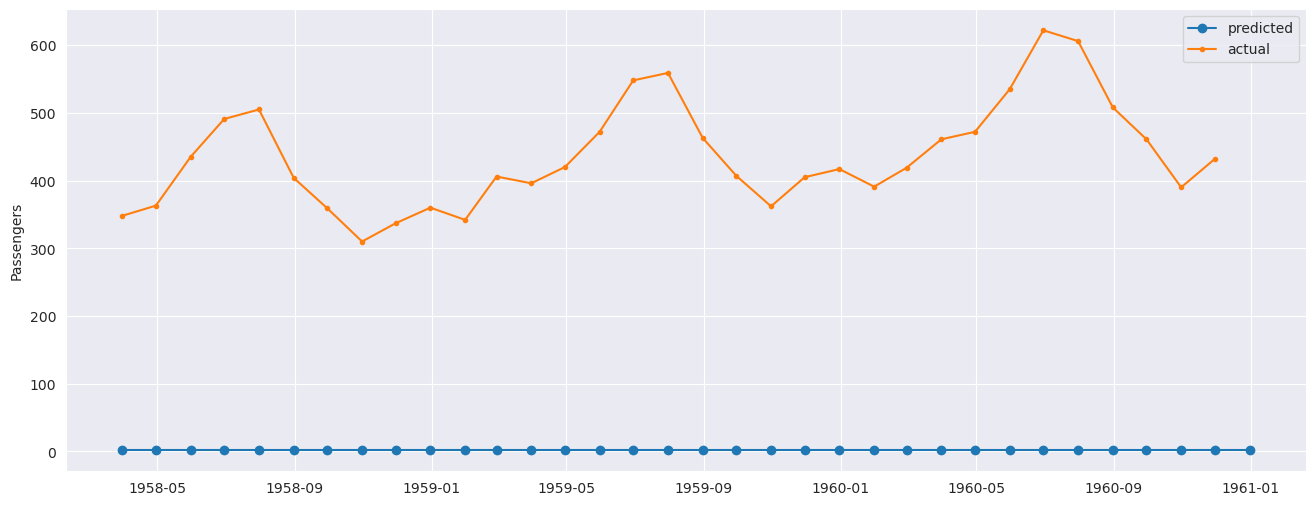

In [16]:
predicted = model.predict(X_test)
show_result(y_test, predicted)